In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b50_k7_b50_k9_b50_k11_b50_k13_b50_k15_b50_k17_b50_k19_b50_k21_b50_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.2494 - STD: 7.5601e-05 - MAE: 0.4871

 4/64 [>.............................] - ETA: 1s - loss: 0.0939 - STD: 3.4281e-04 - MAE: 0.2434  

 5/64 [=>............................] - ETA: 2s - loss: 0.0790 - STD: 3.1097e-04 - MAE: 0.2126

 6/64 [=>............................] - ETA: 2s - loss: 0.0705 - STD: 2.7682e-04 - MAE: 0.1975

 7/64 [==>...........................] - ETA: 2s - loss: 0.0649 - STD: 2.4622e-04 - MAE: 0.1892

 8/64 [==>...........................] - ETA: 2s - loss: 0.0611 - STD: 2.2022e-04 - MAE: 0.1841

 9/64 [===>..........................] - ETA: 2s - loss: 0.0583 - STD: 1.9846e-04 - MAE: 0.1807

10/64 [===>..........................] - ETA: 2s - loss: 0.0561 - STD: 1.8017e-04 - MAE: 0.1782

11/64 [====>.........................] - ETA: 2s - loss: 0.0544 - STD: 1.6477e-04 - MAE: 0.1761

12/64 [====>.........................] - ETA: 2s - loss: 0.0528 - STD: 1.5182e-04 - MAE: 0.1740

13/64 [=====>........................] - ETA: 2s - loss: 0.0514 - STD: 1.4098e-04 - MAE: 0.1719

14/64 [=====>........................] - ETA: 2s - loss: 0.0500 - STD: 1.3185e-04 - MAE: 0.1696

15/64 [======>.......................] - ETA: 2s - loss: 0.0487 - STD: 1.2411e-04 - MAE: 0.1672

16/64 [======>.......................] - ETA: 2s - loss: 0.0474 - STD: 1.1745e-04 - MAE: 0.1642

17/64 [======>.......................] - ETA: 2s - loss: 0.0460 - STD: 1.1165e-04 - MAE: 0.1608

18/64 [=======>......................] - ETA: 2s - loss: 0.0446 - STD: 1.0661e-04 - MAE: 0.1571

19/64 [=======>......................] - ETA: 2s - loss: 0.0432 - STD: 1.0219e-04 - MAE: 0.1529

20/64 [========>.....................] - ETA: 2s - loss: 0.0418 - STD: 9.8303e-05 - MAE: 0.1484

21/64 [========>.....................] - ETA: 2s - loss: 0.0404 - STD: 9.4865e-05 - MAE: 0.1442

22/64 [=========>....................] - ETA: 2s - loss: 0.0392 - STD: 9.1790e-05 - MAE: 0.1406

23/64 [=========>....................] - ETA: 2s - loss: 0.0381 - STD: 8.8993e-05 - MAE: 0.1379

24/64 [==========>...................] - ETA: 2s - loss: 0.0371 - STD: 8.6421e-05 - MAE: 0.1359

25/64 [==========>...................] - ETA: 2s - loss: 0.0362 - STD: 8.4036e-05 - MAE: 0.1346

26/64 [===========>..................] - ETA: 2s - loss: 0.0354 - STD: 8.1806e-05 - MAE: 0.1336

27/64 [===========>..................] - ETA: 2s - loss: 0.0347 - STD: 7.9688e-05 - MAE: 0.1328

28/64 [============>.................] - ETA: 2s - loss: 0.0341 - STD: 7.7683e-05 - MAE: 0.1321

29/64 [============>.................] - ETA: 2s - loss: 0.0335 - STD: 7.5751e-05 - MAE: 0.1313

30/64 [=============>................] - ETA: 1s - loss: 0.0329 - STD: 7.3890e-05 - MAE: 0.1304

31/64 [=============>................] - ETA: 2s - loss: 0.0328 - STD: 7.2076e-05 - MAE: 0.1293

34/64 [==============>...............] - ETA: 2s - loss: 0.0310 - STD: 6.7038e-05 - MAE: 0.1250

36/64 [===============>..............] - ETA: 1s - loss: 0.0300 - STD: 6.3978e-05 - MAE: 0.1217

37/64 [================>.............] - ETA: 1s - loss: 0.0295 - STD: 6.2547e-05 - MAE: 0.1200

38/64 [================>.............] - ETA: 1s - loss: 0.0291 - STD: 6.1180e-05 - MAE: 0.1185

39/64 [=================>............] - ETA: 1s - loss: 0.0287 - STD: 5.9875e-05 - MAE: 0.1170

40/64 [=================>............] - ETA: 1s - loss: 0.0283 - STD: 5.8633e-05 - MAE: 0.1156

41/64 [==================>...........] - ETA: 1s - loss: 0.0279 - STD: 5.7449e-05 - MAE: 0.1142

42/64 [==================>...........] - ETA: 1s - loss: 0.0276 - STD: 5.6323e-05 - MAE: 0.1129

43/64 [===================>..........] - ETA: 1s - loss: 0.0272 - STD: 5.5251e-05 - MAE: 0.1117

44/64 [===================>..........] - ETA: 1s - loss: 0.0269 - STD: 5.4234e-05 - MAE: 0.1105

45/64 [====================>.........] - ETA: 1s - loss: 0.0266 - STD: 5.3268e-05 - MAE: 0.1095

46/64 [====================>.........] - ETA: 1s - loss: 0.0263 - STD: 5.2350e-05 - MAE: 0.1085

47/64 [=====================>........] - ETA: 1s - loss: 0.0260 - STD: 5.1478e-05 - MAE: 0.1076

48/64 [=====================>........] - ETA: 1s - loss: 0.0257 - STD: 5.0646e-05 - MAE: 0.1068

49/64 [=====================>........] - ETA: 1s - loss: 0.0254 - STD: 4.9852e-05 - MAE: 0.1061

50/64 [======================>.......] - ETA: 0s - loss: 0.0252 - STD: 4.9094e-05 - MAE: 0.1054

51/64 [======================>.......] - ETA: 0s - loss: 0.0249 - STD: 4.8371e-05 - MAE: 0.1049

52/64 [=======================>......] - ETA: 0s - loss: 0.0247 - STD: 4.7679e-05 - MAE: 0.1044

53/64 [=======================>......] - ETA: 0s - loss: 0.0245 - STD: 4.7016e-05 - MAE: 0.1040

54/64 [========================>.....] - ETA: 0s - loss: 0.0243 - STD: 4.6379e-05 - MAE: 0.1035

55/64 [========================>.....] - ETA: 0s - loss: 0.0241 - STD: 4.5767e-05 - MAE: 0.1031

56/64 [=========================>....] - ETA: 0s - loss: 0.0239 - STD: 4.5178e-05 - MAE: 0.1026

57/64 [=========================>....] - ETA: 0s - loss: 0.0237 - STD: 4.4612e-05 - MAE: 0.1022

58/64 [==========================>...] - ETA: 0s - loss: 0.0235 - STD: 4.4065e-05 - MAE: 0.1017

59/64 [==========================>...] - ETA: 0s - loss: 0.0233 - STD: 4.3539e-05 - MAE: 0.1012

60/64 [===========================>..] - ETA: 0s - loss: 0.0231 - STD: 4.3028e-05 - MAE: 0.1007

61/64 [===========================>..] - ETA: 0s - loss: 0.0229 - STD: 4.2537e-05 - MAE: 0.1002

62/64 [============================>.] - ETA: 0s - loss: 0.0228 - STD: 4.2061e-05 - MAE: 0.0997

63/64 [============================>.] - ETA: 0s - loss: 0.0226 - STD: 4.1600e-05 - MAE: 0.0991

64/64 [==============================] - ETA: 0s - loss: 0.0224 - STD: 4.1159e-05 - MAE: 0.0986

64/64 [==============================] - 6s 77ms/step - loss: 0.0224 - STD: 4.1159e-05 - MAE: 0.0986 - val_loss: 0.0170 - val_STD: 9.7545e-06 - val_MAE: 0.0748


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0124 - STD: 1.3435e-05 - MAE: 0.0647

 2/64 [..............................] - ETA: 3s - loss: 0.0126 - STD: 1.3592e-05 - MAE: 0.0650

 3/64 [>.............................] - ETA: 3s - loss: 0.0125 - STD: 1.3665e-05 - MAE: 0.0648

 4/64 [>.............................] - ETA: 3s - loss: 0.0126 - STD: 1.3768e-05 - MAE: 0.0651

 5/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 1.3899e-05 - MAE: 0.0654

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 1.4023e-05 - MAE: 0.0657

 7/64 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 1.4144e-05 - MAE: 0.0660

 8/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 1.4263e-05 - MAE: 0.0666

 9/64 [===>..........................] - ETA: 3s - loss: 0.0127 - STD: 1.4403e-05 - MAE: 0.0671

10/64 [===>..........................] - ETA: 3s - loss: 0.0127 - STD: 1.4537e-05 - MAE: 0.0676

11/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 1.4668e-05 - MAE: 0.0680

12/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 1.4815e-05 - MAE: 0.0685

13/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 1.4946e-05 - MAE: 0.0689

14/64 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 1.5078e-05 - MAE: 0.0690

15/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.5202e-05 - MAE: 0.0693

16/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.5337e-05 - MAE: 0.0695

17/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 1.5464e-05 - MAE: 0.0696

18/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 1.5586e-05 - MAE: 0.0697

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 1.5704e-05 - MAE: 0.0697

20/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.5832e-05 - MAE: 0.0697

21/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 1.5950e-05 - MAE: 0.0697

22/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.6071e-05 - MAE: 0.0696

23/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 1.6200e-05 - MAE: 0.0696

24/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 1.6328e-05 - MAE: 0.0696

25/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 1.6457e-05 - MAE: 0.0695

26/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 1.6593e-05 - MAE: 0.0694

27/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 1.6726e-05 - MAE: 0.0694

28/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 1.6864e-05 - MAE: 0.0694

29/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 1.7002e-05 - MAE: 0.0694

30/64 [=============>................] - ETA: 2s - loss: 0.0127 - STD: 1.7147e-05 - MAE: 0.0694

31/64 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 1.7299e-05 - MAE: 0.0694

32/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 1.7456e-05 - MAE: 0.0695

33/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 1.7615e-05 - MAE: 0.0695

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 1.7777e-05 - MAE: 0.0696

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 1.7941e-05 - MAE: 0.0696

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 1.8104e-05 - MAE: 0.0696

37/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 1.8279e-05 - MAE: 0.0697

38/64 [================>.............] - ETA: 1s - loss: 0.0127 - STD: 1.8450e-05 - MAE: 0.0697

39/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 1.8617e-05 - MAE: 0.0697

40/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 1.8790e-05 - MAE: 0.0698

42/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 1.9146e-05 - MAE: 0.0698

43/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 1.9328e-05 - MAE: 0.0699

44/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 1.9514e-05 - MAE: 0.0699

45/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 1.9698e-05 - MAE: 0.0699

46/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 1.9886e-05 - MAE: 0.0699

47/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.0079e-05 - MAE: 0.0699

48/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.0275e-05 - MAE: 0.0699

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.0474e-05 - MAE: 0.0699

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.0672e-05 - MAE: 0.0699

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 2.0875e-05 - MAE: 0.0699

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.1086e-05 - MAE: 0.0699

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.1302e-05 - MAE: 0.0699

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.1520e-05 - MAE: 0.0699

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 2.1748e-05 - MAE: 0.0699

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.1980e-05 - MAE: 0.0699

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.2214e-05 - MAE: 0.0699

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 2.2455e-05 - MAE: 0.0699

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 2.2698e-05 - MAE: 0.0699

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.2948e-05 - MAE: 0.0699

61/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.3197e-05 - MAE: 0.0699

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 2.3453e-05 - MAE: 0.0700

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 2.3718e-05 - MAE: 0.0700

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 2.3986e-05 - MAE: 0.0700

64/64 [==============================] - 4s 61ms/step - loss: 0.0127 - STD: 2.3986e-05 - MAE: 0.0700 - val_loss: 0.0168 - val_STD: 2.9843e-05 - val_MAE: 0.0795


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0127 - STD: 4.1782e-05 - MAE: 0.0701

 2/64 [..............................] - ETA: 4s - loss: 0.0129 - STD: 4.2383e-05 - MAE: 0.0707

 3/64 [>.............................] - ETA: 3s - loss: 0.0128 - STD: 4.2859e-05 - MAE: 0.0702

 4/64 [>.............................] - ETA: 3s - loss: 0.0126 - STD: 4.3223e-05 - MAE: 0.0701

 5/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 4.3699e-05 - MAE: 0.0699

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 4.4193e-05 - MAE: 0.0697

 7/64 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 4.4691e-05 - MAE: 0.0697

 8/64 [==>...........................] - ETA: 3s - loss: 0.0125 - STD: 4.5158e-05 - MAE: 0.0696

 9/64 [===>..........................] - ETA: 3s - loss: 0.0125 - STD: 4.5671e-05 - MAE: 0.0694

10/64 [===>..........................] - ETA: 3s - loss: 0.0125 - STD: 4.6238e-05 - MAE: 0.0694

11/64 [====>.........................] - ETA: 3s - loss: 0.0125 - STD: 4.6821e-05 - MAE: 0.0694

12/64 [====>.........................] - ETA: 3s - loss: 0.0125 - STD: 4.7384e-05 - MAE: 0.0693

13/64 [=====>........................] - ETA: 3s - loss: 0.0125 - STD: 4.8007e-05 - MAE: 0.0693

14/64 [=====>........................] - ETA: 2s - loss: 0.0126 - STD: 4.8632e-05 - MAE: 0.0694

15/64 [======>.......................] - ETA: 2s - loss: 0.0126 - STD: 4.9263e-05 - MAE: 0.0694

16/64 [======>.......................] - ETA: 2s - loss: 0.0126 - STD: 4.9932e-05 - MAE: 0.0696

17/64 [======>.......................] - ETA: 2s - loss: 0.0126 - STD: 5.0596e-05 - MAE: 0.0696

18/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 5.1318e-05 - MAE: 0.0697

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 5.2030e-05 - MAE: 0.0698

20/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 5.2807e-05 - MAE: 0.0699

21/64 [========>.....................] - ETA: 2s - loss: 0.0127 - STD: 5.3544e-05 - MAE: 0.0699

22/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 5.4329e-05 - MAE: 0.0699

23/64 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 5.5134e-05 - MAE: 0.0700

24/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 5.5985e-05 - MAE: 0.0701

25/64 [==========>...................] - ETA: 2s - loss: 0.0127 - STD: 5.6809e-05 - MAE: 0.0700

26/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 5.7641e-05 - MAE: 0.0700

27/64 [===========>..................] - ETA: 2s - loss: 0.0127 - STD: 5.8550e-05 - MAE: 0.0700

28/64 [============>.................] - ETA: 2s - loss: 0.0127 - STD: 5.9442e-05 - MAE: 0.0700

30/64 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 6.1295e-05 - MAE: 0.0699

31/64 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 6.2279e-05 - MAE: 0.0699

32/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 6.3282e-05 - MAE: 0.0699

33/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 6.4316e-05 - MAE: 0.0699

34/64 [==============>...............] - ETA: 1s - loss: 0.0127 - STD: 6.5390e-05 - MAE: 0.0698

35/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 6.6497e-05 - MAE: 0.0698

36/64 [===============>..............] - ETA: 1s - loss: 0.0127 - STD: 6.7642e-05 - MAE: 0.0698

37/64 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 6.8819e-05 - MAE: 0.0698

38/64 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 7.0032e-05 - MAE: 0.0697

39/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 7.1312e-05 - MAE: 0.0698

40/64 [=================>............] - ETA: 1s - loss: 0.0127 - STD: 7.2631e-05 - MAE: 0.0699

41/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 7.3944e-05 - MAE: 0.0699

42/64 [==================>...........] - ETA: 1s - loss: 0.0127 - STD: 7.5321e-05 - MAE: 0.0699

43/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 7.6744e-05 - MAE: 0.0699

44/64 [===================>..........] - ETA: 1s - loss: 0.0127 - STD: 7.8208e-05 - MAE: 0.0699

45/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 7.9690e-05 - MAE: 0.0699

46/64 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 8.1251e-05 - MAE: 0.0699

47/64 [=====================>........] - ETA: 1s - loss: 0.0127 - STD: 8.2807e-05 - MAE: 0.0699

48/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 8.4456e-05 - MAE: 0.0700

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 8.6125e-05 - MAE: 0.0700

50/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 8.7842e-05 - MAE: 0.0700

51/64 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 8.9600e-05 - MAE: 0.0700

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 9.1440e-05 - MAE: 0.0700

53/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 9.3319e-05 - MAE: 0.0700

54/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 9.5262e-05 - MAE: 0.0700

55/64 [========================>.....] - ETA: 0s - loss: 0.0127 - STD: 9.7232e-05 - MAE: 0.0700

56/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 9.9301e-05 - MAE: 0.0700

57/64 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 1.0147e-04 - MAE: 0.0700

58/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.0370e-04 - MAE: 0.0700

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 1.0600e-04 - MAE: 0.0700

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 1.0839e-04 - MAE: 0.0700

61/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 1.1088e-04 - MAE: 0.0700

62/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.1344e-04 - MAE: 0.0700

63/64 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 1.1607e-04 - MAE: 0.0700

64/64 [==============================] - ETA: 0s - loss: 0.0127 - STD: 1.1881e-04 - MAE: 0.0700

64/64 [==============================] - 4s 62ms/step - loss: 0.0127 - STD: 1.1881e-04 - MAE: 0.0700 - val_loss: 0.0167 - val_STD: 2.1716e-04 - val_MAE: 0.0798


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0126 - STD: 3.0535e-04 - MAE: 0.0707

 2/64 [..............................] - ETA: 5s - loss: 0.0125 - STD: 3.1074e-04 - MAE: 0.0701

 3/64 [>.............................] - ETA: 4s - loss: 0.0126 - STD: 3.1618e-04 - MAE: 0.0703

 4/64 [>.............................] - ETA: 3s - loss: 0.0126 - STD: 3.2308e-04 - MAE: 0.0703

 5/64 [=>............................] - ETA: 3s - loss: 0.0127 - STD: 3.2977e-04 - MAE: 0.0705

 6/64 [=>............................] - ETA: 3s - loss: 0.0126 - STD: 3.3684e-04 - MAE: 0.0703

 7/64 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 3.4377e-04 - MAE: 0.0702

 8/64 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 3.5142e-04 - MAE: 0.0703

 9/64 [===>..........................] - ETA: 3s - loss: 0.0127 - STD: 3.5906e-04 - MAE: 0.0702

10/64 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 3.6685e-04 - MAE: 0.0700

11/64 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 3.7529e-04 - MAE: 0.0701

12/64 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 3.8428e-04 - MAE: 0.0701

13/64 [=====>........................] - ETA: 3s - loss: 0.0127 - STD: 3.9388e-04 - MAE: 0.0701

14/64 [=====>........................] - ETA: 2s - loss: 0.0127 - STD: 4.0330e-04 - MAE: 0.0701

15/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 4.1344e-04 - MAE: 0.0701

16/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 4.2401e-04 - MAE: 0.0702

17/64 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 4.3499e-04 - MAE: 0.0702

18/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 4.4634e-04 - MAE: 0.0702

19/64 [=======>......................] - ETA: 2s - loss: 0.0127 - STD: 4.5801e-04 - MAE: 0.0702

20/64 [========>.....................] - ETA: 2s - loss: 0.0126 - STD: 4.7011e-04 - MAE: 0.0701

21/64 [========>.....................] - ETA: 2s - loss: 0.0126 - STD: 4.8268e-04 - MAE: 0.0701

22/64 [=========>....................] - ETA: 2s - loss: 0.0126 - STD: 4.9548e-04 - MAE: 0.0700

23/64 [=========>....................] - ETA: 2s - loss: 0.0126 - STD: 5.0903e-04 - MAE: 0.0700

24/64 [==========>...................] - ETA: 2s - loss: 0.0126 - STD: 5.2312e-04 - MAE: 0.0699

25/64 [==========>...................] - ETA: 2s - loss: 0.0126 - STD: 5.3772e-04 - MAE: 0.0699

26/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 5.5350e-04 - MAE: 0.0698

27/64 [===========>..................] - ETA: 2s - loss: 0.0126 - STD: 5.6960e-04 - MAE: 0.0698

28/64 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 5.8681e-04 - MAE: 0.0698

29/64 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 6.0479e-04 - MAE: 0.0698

30/64 [=============>................] - ETA: 2s - loss: 0.0126 - STD: 6.2350e-04 - MAE: 0.0697

31/64 [=============>................] - ETA: 1s - loss: 0.0126 - STD: 6.4317e-04 - MAE: 0.0698

32/64 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 6.6385e-04 - MAE: 0.0698

33/64 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 6.8568e-04 - MAE: 0.0698

34/64 [==============>...............] - ETA: 1s - loss: 0.0126 - STD: 7.0790e-04 - MAE: 0.0698

35/64 [===============>..............] - ETA: 1s - loss: 0.0126 - STD: 7.3137e-04 - MAE: 0.0698

36/64 [===============>..............] - ETA: 1s - loss: 0.0126 - STD: 7.5541e-04 - MAE: 0.0698

37/64 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 7.8083e-04 - MAE: 0.0698

38/64 [================>.............] - ETA: 1s - loss: 0.0126 - STD: 8.0698e-04 - MAE: 0.0697

39/64 [=================>............] - ETA: 1s - loss: 0.0126 - STD: 8.3475e-04 - MAE: 0.0697

40/64 [=================>............] - ETA: 1s - loss: 0.0126 - STD: 8.6387e-04 - MAE: 0.0697

41/64 [==================>...........] - ETA: 1s - loss: 0.0126 - STD: 8.9477e-04 - MAE: 0.0697

42/64 [==================>...........] - ETA: 1s - loss: 0.0126 - STD: 9.2761e-04 - MAE: 0.0697

43/64 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 9.6236e-04 - MAE: 0.0697

44/64 [===================>..........] - ETA: 1s - loss: 0.0126 - STD: 9.9959e-04 - MAE: 0.0697

46/64 [====================>.........] - ETA: 1s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0697    

47/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 0.0011 - MAE: 0.0698

48/64 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0698

49/64 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0698

50/64 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0698

51/64 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0698

52/64 [=======================>......] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0698

53/64 [=======================>......] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0697

54/64 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0697

55/64 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0015 - MAE: 0.0696

57/64 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0017 - MAE: 0.0695

58/64 [==========================>...] - ETA: 0s - loss: 0.0125 - STD: 0.0018 - MAE: 0.0695

59/64 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.0018 - MAE: 0.0695

61/64 [===========================>..] - ETA: 0s - loss: 0.0124 - STD: 0.0020 - MAE: 0.0694

62/64 [============================>.] - ETA: 0s - loss: 0.0124 - STD: 0.0021 - MAE: 0.0693

63/64 [============================>.] - ETA: 0s - loss: 0.0124 - STD: 0.0022 - MAE: 0.0693

64/64 [==============================] - ETA: 0s - loss: 0.0124 - STD: 0.0023 - MAE: 0.0692

64/64 [==============================] - 4s 61ms/step - loss: 0.0124 - STD: 0.0023 - MAE: 0.0692 - val_loss: 0.0151 - val_STD: 0.0066 - val_MAE: 0.0748


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0113 - STD: 0.0094 - MAE: 0.0662

 2/64 [..............................] - ETA: 4s - loss: 0.0113 - STD: 0.0097 - MAE: 0.0660

 3/64 [>.............................] - ETA: 4s - loss: 0.0111 - STD: 0.0101 - MAE: 0.0657

 4/64 [>.............................] - ETA: 3s - loss: 0.0110 - STD: 0.0104 - MAE: 0.0656

 5/64 [=>............................] - ETA: 3s - loss: 0.0111 - STD: 0.0107 - MAE: 0.0655

 6/64 [=>............................] - ETA: 3s - loss: 0.0110 - STD: 0.0110 - MAE: 0.0654

 7/64 [==>...........................] - ETA: 3s - loss: 0.0110 - STD: 0.0114 - MAE: 0.0653

 8/64 [==>...........................] - ETA: 3s - loss: 0.0109 - STD: 0.0118 - MAE: 0.0650

 9/64 [===>..........................] - ETA: 3s - loss: 0.0109 - STD: 0.0121 - MAE: 0.0648

10/64 [===>..........................] - ETA: 3s - loss: 0.0108 - STD: 0.0126 - MAE: 0.0647

11/64 [====>.........................] - ETA: 3s - loss: 0.0107 - STD: 0.0130 - MAE: 0.0644

12/64 [====>.........................] - ETA: 3s - loss: 0.0107 - STD: 0.0134 - MAE: 0.0641

13/64 [=====>........................] - ETA: 3s - loss: 0.0107 - STD: 0.0139 - MAE: 0.0641

14/64 [=====>........................] - ETA: 3s - loss: 0.0106 - STD: 0.0144 - MAE: 0.0639

15/64 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 0.0149 - MAE: 0.0637

16/64 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.0154 - MAE: 0.0635

17/64 [======>.......................] - ETA: 3s - loss: 0.0104 - STD: 0.0159 - MAE: 0.0634

18/64 [=======>......................] - ETA: 2s - loss: 0.0104 - STD: 0.0165 - MAE: 0.0632

19/64 [=======>......................] - ETA: 2s - loss: 0.0103 - STD: 0.0170 - MAE: 0.0629

20/64 [========>.....................] - ETA: 2s - loss: 0.0102 - STD: 0.0176 - MAE: 0.0627

21/64 [========>.....................] - ETA: 2s - loss: 0.0101 - STD: 0.0182 - MAE: 0.0624

22/64 [=========>....................] - ETA: 2s - loss: 0.0101 - STD: 0.0188 - MAE: 0.0622

23/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 0.0194 - MAE: 0.0619

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 0.0201 - MAE: 0.0616

25/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 0.0208 - MAE: 0.0613

26/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0215 - MAE: 0.0610

27/64 [===========>..................] - ETA: 2s - loss: 0.0096 - STD: 0.0222 - MAE: 0.0607

29/64 [============>.................] - ETA: 2s - loss: 0.0095 - STD: 0.0237 - MAE: 0.0600

30/64 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.0245 - MAE: 0.0597

31/64 [=============>................] - ETA: 2s - loss: 0.0093 - STD: 0.0253 - MAE: 0.0594

32/64 [==============>...............] - ETA: 1s - loss: 0.0093 - STD: 0.0262 - MAE: 0.0591

33/64 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 0.0270 - MAE: 0.0588

34/64 [==============>...............] - ETA: 1s - loss: 0.0091 - STD: 0.0278 - MAE: 0.0585

35/64 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.0286 - MAE: 0.0582

36/64 [===============>..............] - ETA: 1s - loss: 0.0089 - STD: 0.0294 - MAE: 0.0578

37/64 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.0303 - MAE: 0.0575

38/64 [================>.............] - ETA: 1s - loss: 0.0087 - STD: 0.0312 - MAE: 0.0571

39/64 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.0321 - MAE: 0.0568

40/64 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0330 - MAE: 0.0565

41/64 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.0339 - MAE: 0.0562

42/64 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0347 - MAE: 0.0559

43/64 [===================>..........] - ETA: 1s - loss: 0.0082 - STD: 0.0355 - MAE: 0.0555

44/64 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.0364 - MAE: 0.0552

45/64 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0373 - MAE: 0.0549

46/64 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0382 - MAE: 0.0546

47/64 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0389 - MAE: 0.0543

48/64 [=====================>........] - ETA: 1s - loss: 0.0078 - STD: 0.0397 - MAE: 0.0540

49/64 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.0406 - MAE: 0.0537

50/64 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0415 - MAE: 0.0534

51/64 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0422 - MAE: 0.0532

52/64 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0430 - MAE: 0.0529

53/64 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0438 - MAE: 0.0526

54/64 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0446 - MAE: 0.0524

55/64 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0453 - MAE: 0.0521

56/64 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0461 - MAE: 0.0519

57/64 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0468 - MAE: 0.0516

58/64 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0475 - MAE: 0.0514

59/64 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0482 - MAE: 0.0512

60/64 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0489 - MAE: 0.0509

61/64 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0496 - MAE: 0.0507

62/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0502 - MAE: 0.0505

63/64 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0509 - MAE: 0.0503

64/64 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0516 - MAE: 0.0500

64/64 [==============================] - 4s 65ms/step - loss: 0.0067 - STD: 0.0516 - MAE: 0.0500 - val_loss: 0.0039 - val_STD: 0.0649 - val_MAE: 0.0403


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0899 - MAE: 0.0359

 2/64 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0891 - MAE: 0.0358

 3/64 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0903 - MAE: 0.0357

 4/64 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0912 - MAE: 0.0357

 5/64 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0913 - MAE: 0.0358

 6/64 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0918 - MAE: 0.0357

 7/64 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0921 - MAE: 0.0356

 8/64 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0925 - MAE: 0.0356

 9/64 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0925 - MAE: 0.0355

10/64 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0930 - MAE: 0.0354

11/64 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0932 - MAE: 0.0354

12/64 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0934 - MAE: 0.0353

13/64 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0933 - MAE: 0.0353

14/64 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0934 - MAE: 0.0352

15/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0938 - MAE: 0.0351

16/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0939 - MAE: 0.0350

17/64 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0939 - MAE: 0.0350

18/64 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0941 - MAE: 0.0349

19/64 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0348

20/64 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0348

21/64 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0943 - MAE: 0.0347

22/64 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0944 - MAE: 0.0347

23/64 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0346

24/64 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0946 - MAE: 0.0345

25/64 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0947 - MAE: 0.0345

26/64 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0344

27/64 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0948 - MAE: 0.0343

28/64 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0343

29/64 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0342

30/64 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0341

31/64 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0341

32/64 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0341

33/64 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0340

34/64 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0339

35/64 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0954 - MAE: 0.0339

36/64 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0954 - MAE: 0.0338

37/64 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0338

38/64 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0337

39/64 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0336

40/64 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0336

41/64 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0335

42/64 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0335

43/64 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0334

44/64 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0334

45/64 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0333

46/64 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0333

47/64 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0332

49/64 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0332

50/64 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0332

51/64 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0332

52/64 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0331

53/64 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0331

54/64 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0331

55/64 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0330

56/64 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0330

57/64 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0330

58/64 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

59/64 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

60/64 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0329

61/64 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0328

62/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0328

63/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0328

64/64 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0327

64/64 [==============================] - 5s 74ms/step - loss: 0.0024 - STD: 0.0972 - MAE: 0.0327 - val_loss: 0.0023 - val_STD: 0.0846 - val_MAE: 0.0326


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0307

 2/64 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0308

 4/64 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0307

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0307

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0307

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0307

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0306

 9/64 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0307

10/64 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0307

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0306

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0306

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0306

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0306

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0305

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0305

17/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0305

18/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1009 - MAE: 0.0305

19/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0305

20/64 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0305

21/64 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1010 - MAE: 0.0305

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0305

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0305

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0305

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0305

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0305

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0305

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0305

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0305

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0305

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0305

32/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0305

33/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0305

34/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0305

35/64 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0305

36/64 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0305

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0305

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1011 - MAE: 0.0305

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0305

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0305

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0305

42/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

46/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

47/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0304

48/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

49/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

50/64 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

53/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0303

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0303

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0302

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0302

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0302

59/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0302

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0302

61/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0302

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0302

63/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0302

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1016 - MAE: 0.0301

64/64 [==============================] - 5s 81ms/step - loss: 0.0020 - STD: 0.1016 - MAE: 0.0301 - val_loss: 0.0022 - val_STD: 0.0891 - val_MAE: 0.0317


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1075 - MAE: 0.0303

 2/64 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0299

 3/64 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0298

 4/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299

 5/64 [=>............................] - ETA: 5s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

 6/64 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

 7/64 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0296

 8/64 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0295

 9/64 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0295

10/64 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0295

11/64 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1026 - MAE: 0.0295

12/64 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0295

13/64 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0295

14/64 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0295

15/64 [======>.......................] - ETA: 4s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0295

16/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0294

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0294

18/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0294

19/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1025 - MAE: 0.0295

20/64 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0295

21/64 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0294

22/64 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0294

23/64 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0295

24/64 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1022 - MAE: 0.0294

25/64 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0294

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0294

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0294

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0294

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0294

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0294

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0294

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0293

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0293

34/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0293

35/64 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0293

36/64 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0293

37/64 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

38/64 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0293

39/64 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0293

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0293

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0293

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0293

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0293

49/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0293

50/64 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

51/64 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0293

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0292

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0293

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0292

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0292

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0292

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0292

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0292

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0292

64/64 [==============================] - 5s 82ms/step - loss: 0.0018 - STD: 0.1029 - MAE: 0.0292 - val_loss: 0.0020 - val_STD: 0.0890 - val_MAE: 0.0302


Epoch 9/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0286

 2/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0285

 3/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

 5/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

 6/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

20/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

21/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

22/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

23/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0284

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0284

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

35/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

36/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

37/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

50/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

51/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0283

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

64/64 [==============================] - 5s 81ms/step - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283 - val_loss: 0.0020 - val_STD: 0.0855 - val_MAE: 0.0304


Epoch 10/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0291

 2/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0284

 3/64 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0285

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0283

 7/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

 8/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0285

10/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0285

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0285

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

20/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

21/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

22/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

35/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

36/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

37/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

38/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

50/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0279

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

64/64 [==============================] - 5s 81ms/step - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279 - val_loss: 0.0019 - val_STD: 0.0915 - val_MAE: 0.0289


Epoch 11/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0271

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0272

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0275

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0275

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

 7/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0276

 8/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

10/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

11/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

12/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

37/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

50/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

51/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0278

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277

64/64 [==============================] - 5s 81ms/step - loss: 0.0016 - STD: 0.1044 - MAE: 0.0277 - val_loss: 0.0018 - val_STD: 0.0903 - val_MAE: 0.0285


Epoch 12/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0273

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

 6/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

 7/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

 8/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0272

10/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0271

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

51/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

64/64 [==============================] - 5s 81ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271 - val_loss: 0.0021 - val_STD: 0.0964 - val_MAE: 0.0306


Epoch 13/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0017 - STD: 0.1089 - MAE: 0.0290

 2/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0283

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0280

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0279

 6/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

 8/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

 9/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

10/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

11/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0281

12/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0280

13/64 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

64/64 [==============================] - 5s 81ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0933 - val_MAE: 0.0284


Epoch 14/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0268

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0266

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0265

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - 5s 78ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.0925 - val_MAE: 0.0281


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0260

 2/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0263

 3/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0263

 5/64 [=>............................] - ETA: 5s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0263

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0262

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0262

11/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0263

13/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

14/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0263

15/64 [======>.......................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0263

16/64 [======>.......................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

24/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

25/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

26/64 [===========>..................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

38/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 5s 82ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0945 - val_MAE: 0.0281


Epoch 16/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0262

 4/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0261

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0261

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0261

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

51/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

64/64 [==============================] - 5s 80ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263 - val_loss: 0.0019 - val_STD: 0.0963 - val_MAE: 0.0290


Epoch 17/10000


 1/64 [..............................] - ETA: 9s - loss: 0.0015 - STD: 0.1129 - MAE: 0.0269

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1087 - MAE: 0.0265

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

 4/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0267

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

11/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

13/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - 5s 80ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0953 - val_MAE: 0.0283


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0266

 2/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0261

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

11/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

13/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

24/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

25/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

38/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

51/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - 5s 82ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0939 - val_MAE: 0.0276


Epoch 19/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

 3/64 [>.............................] - ETA: 5s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0263

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0260

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

11/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0258

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

25/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

38/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

51/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - 5s 80ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0942 - val_MAE: 0.0279


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1099 - MAE: 0.0254

 2/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1119 - MAE: 0.0291

 3/64 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0298

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1066 - MAE: 0.0290

 5/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1079 - MAE: 0.0301

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0295

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0296

 9/64 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0292

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0292

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0289

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0289

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0288

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0287

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0287

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0285

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0285

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0283

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

20/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0283

21/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0282

22/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0282

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0281

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0280

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0279

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0279

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0278

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - 5s 80ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.0952 - val_MAE: 0.0275


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0260

 2/64 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0258

 3/64 [>.............................] - ETA: 5s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

 4/64 [>.............................] - ETA: 5s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

 5/64 [=>............................] - ETA: 5s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0256

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0257

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0257

11/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0258

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0258

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0258

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0258

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

25/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0258

26/64 [===========>..................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

51/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

64/64 [==============================] - 5s 81ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257 - val_loss: 0.0017 - val_STD: 0.0946 - val_MAE: 0.0274


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

 2/64 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0256

 3/64 [>.............................] - ETA: 5s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0256

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0257

 5/64 [=>............................] - ETA: 5s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

11/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

12/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

13/64 [=====>........................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

14/64 [=====>........................] - ETA: 4s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

15/64 [======>.......................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

38/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 5s 81ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0964 - val_MAE: 0.0279


Epoch 23/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0013 - STD: 0.1103 - MAE: 0.0254

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0256

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0259

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0259

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0258

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

25/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - 5s 77ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257 - val_loss: 0.0019 - val_STD: 0.0972 - val_MAE: 0.0290


Epoch 24/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0268

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

 3/64 [>.............................] - ETA: 5s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

 5/64 [=>............................] - ETA: 5s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

12/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

38/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - 5s 81ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0017 - val_STD: 0.0955 - val_MAE: 0.0274


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0252

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1084 - MAE: 0.0255

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0256

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0256

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0254

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

25/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

51/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - 5s 79ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0969 - val_MAE: 0.0285


Epoch 26/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0013 - STD: 0.1085 - MAE: 0.0258

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0260

 3/64 [>.............................] - ETA: 5s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

11/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

12/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

13/64 [=====>........................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

25/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

38/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - 5s 79ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0017 - val_STD: 0.0949 - val_MAE: 0.0276


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1021 - MAE: 0.0252

 2/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0253

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0253

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0250

10/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0250

11/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0251

12/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0251

13/64 [=====>........................] - ETA: 4s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0251

14/64 [=====>........................] - ETA: 4s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

20/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

21/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

22/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

23/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

24/64 [==========>...................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

25/64 [==========>...................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

26/64 [===========>..................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

35/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

37/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

38/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

50/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

51/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

64/64 [==============================] - 5s 83ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253 - val_loss: 0.0017 - val_STD: 0.0952 - val_MAE: 0.0274


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0250

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

 3/64 [>.............................] - ETA: 5s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

 5/64 [=>............................] - ETA: 5s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0251

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

10/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

11/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

20/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

21/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

22/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

23/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

24/64 [==========>...................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

51/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

64/64 [==============================] - 5s 81ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0016 - val_STD: 0.0947 - val_MAE: 0.0273


Epoch 29/10000


 1/64 [..............................] - ETA: 9s - loss: 0.0013 - STD: 0.1033 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0252

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0251

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0253

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0254

11/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0253

12/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0253

13/64 [=====>........................] - ETA: 4s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0253

14/64 [=====>........................] - ETA: 4s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0253

15/64 [======>.......................] - ETA: 4s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0252

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0252

20/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

21/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

22/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

23/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0251

24/64 [==========>...................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0252

25/64 [==========>...................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0252

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0252

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0252

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0253

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0253

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0253

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0253

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0253

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

35/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

36/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

37/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

38/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0253

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

50/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

51/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - 5s 81ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252 - val_loss: 0.0017 - val_STD: 0.0917 - val_MAE: 0.0281


Epoch 30/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0266

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0261

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0256

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0256

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0254

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0253

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

35/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

36/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

37/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - 5s 79ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253 - val_loss: 0.0016 - val_STD: 0.0939 - val_MAE: 0.0274


Epoch 31/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0256

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

10/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

11/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

12/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

13/64 [=====>........................] - ETA: 4s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

20/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

21/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

22/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

23/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

24/64 [==========>...................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

35/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

37/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

50/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

64/64 [==============================] - 5s 80ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251 - val_loss: 0.0019 - val_STD: 0.0990 - val_MAE: 0.0286


Epoch 32/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0255

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1080 - MAE: 0.0254

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0252

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0251

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

20/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

21/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

22/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

23/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

24/64 [==========>...................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

25/64 [==========>...................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

35/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

36/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

37/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

50/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

64/64 [==============================] - 5s 79ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252 - val_loss: 0.0018 - val_STD: 0.0982 - val_MAE: 0.0280


Epoch 33/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0013 - STD: 0.1085 - MAE: 0.0248

 2/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0249

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0249

 4/64 [>.............................] - ETA: 5s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0248

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0247

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1083 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1082 - MAE: 0.0248

 8/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1080 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1081 - MAE: 0.0248

10/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1078 - MAE: 0.0249

11/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0249

12/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0249

13/64 [=====>........................] - ETA: 4s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0249

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0249

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0249

20/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

21/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0249

22/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

23/64 [=========>....................] - ETA: 3s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

34/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

35/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

36/64 [===============>..............] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0250

37/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

38/64 [================>.............] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

50/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

64/64 [==============================] - 5s 81ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252 - val_loss: 0.0019 - val_STD: 0.0984 - val_MAE: 0.0281


Epoch 34/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

 2/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0251

 3/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0250

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0250

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0251

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

10/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0251

11/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0254

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0256

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0256

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0256

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0256

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

24/64 [==========>...................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0254

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

49/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

50/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

51/64 [======================>.......] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 5s 81ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0017 - val_STD: 0.0972 - val_MAE: 0.0274


Epoch 35/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

 3/64 [>.............................] - ETA: 5s - loss: 0.0013 - STD: 0.1085 - MAE: 0.0248

 4/64 [>.............................] - ETA: 4s - loss: 0.0013 - STD: 0.1079 - MAE: 0.0246

 5/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0246

 6/64 [=>............................] - ETA: 4s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0246

 7/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0247

 8/64 [==>...........................] - ETA: 4s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

 9/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

10/64 [===>..........................] - ETA: 4s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

11/64 [====>.........................] - ETA: 4s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

13/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

14/64 [=====>........................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

15/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

16/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

17/64 [======>.......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

18/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

19/64 [=======>......................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

20/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

21/64 [========>.....................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

30/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

31/64 [=============>................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

32/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

33/64 [==============>...............] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

48/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

64/64 [==============================] - 4s 65ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251 - val_loss: 0.0017 - val_STD: 0.0935 - val_MAE: 0.0277


Epoch 36/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0013 - STD: 0.1011 - MAE: 0.0252

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1051 - MAE: 0.0249

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0250

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0251

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0250

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0250

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0250

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0250

11/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

12/64 [====>.........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

13/64 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

14/64 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

15/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

16/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

17/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

26/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

29/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

30/64 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

31/64 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

32/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

47/64 [=====================>........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

64/64 [==============================] - 4s 61ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250 - val_loss: 0.0017 - val_STD: 0.0966 - val_MAE: 0.0273


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0242

 2/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1092 - MAE: 0.0246

 3/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1084 - MAE: 0.0249

 4/64 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0247

 5/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0247

 6/64 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

 7/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

 8/64 [==>...........................] - ETA: 3s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

 9/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0247

10/64 [===>..........................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

11/64 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

12/64 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

13/64 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

14/64 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0247

15/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

16/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

17/64 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

18/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

19/64 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

20/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

21/64 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

22/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

23/64 [=========>....................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

24/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

25/64 [==========>...................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

27/64 [===========>..................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

28/64 [============>.................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

29/64 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

30/64 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

31/64 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

32/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

33/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

34/64 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

35/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

36/64 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

37/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

38/64 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

39/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

40/64 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

41/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

42/64 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

43/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

44/64 [===================>..........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

45/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

46/64 [====================>.........] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

57/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

63/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

64/64 [==============================] - 4s 61ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250 - val_loss: 0.0017 - val_STD: 0.0962 - val_MAE: 0.0274


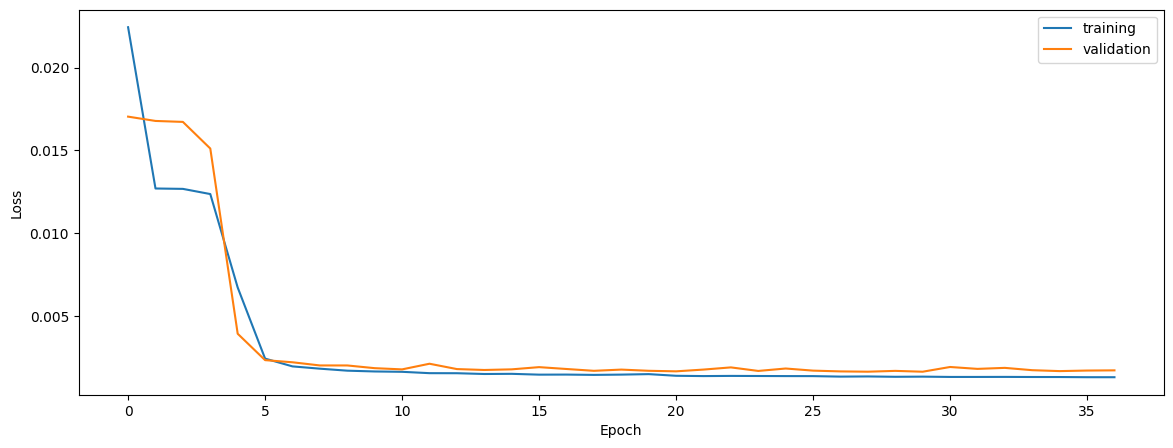

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9472721749101952
0.9506827582159212
0.9454189427820557


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9472721749101952
0.9506827582159212
0.9454189427820557


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9530181610139021
0.9547443336022914
0.9557963835911301


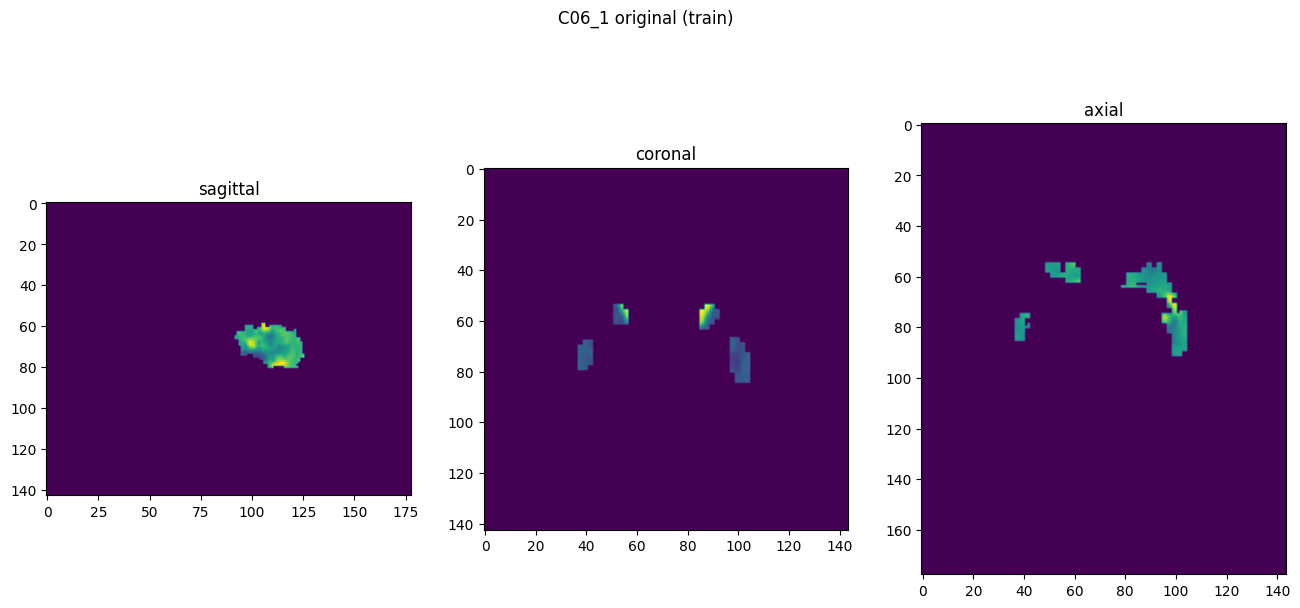

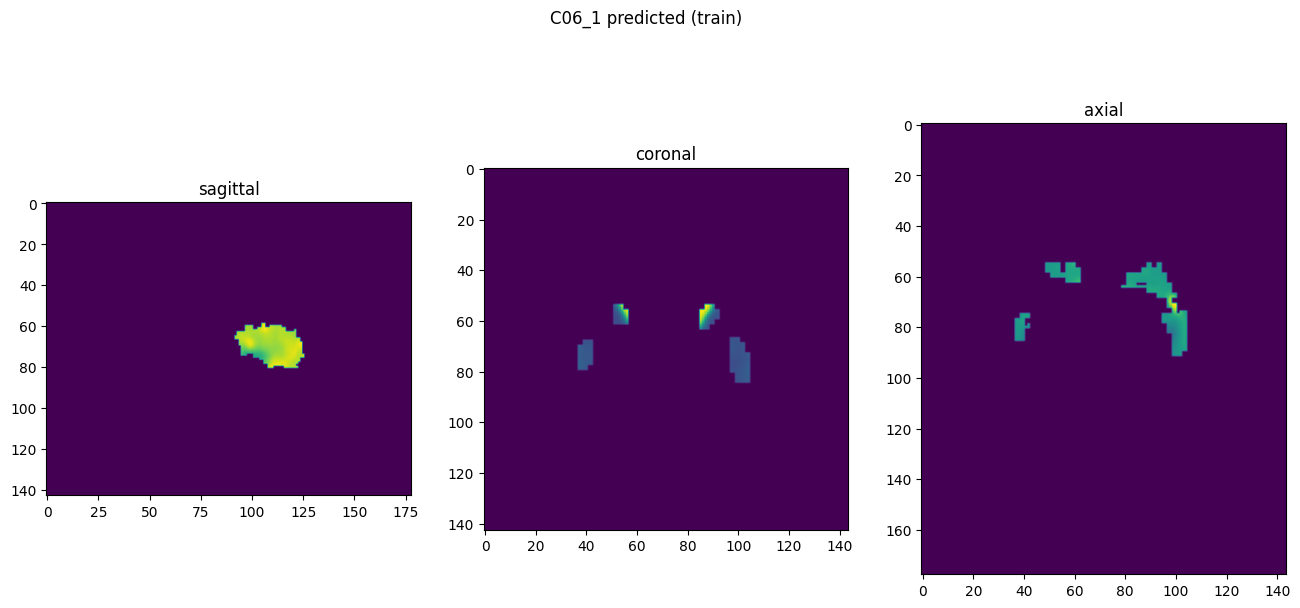

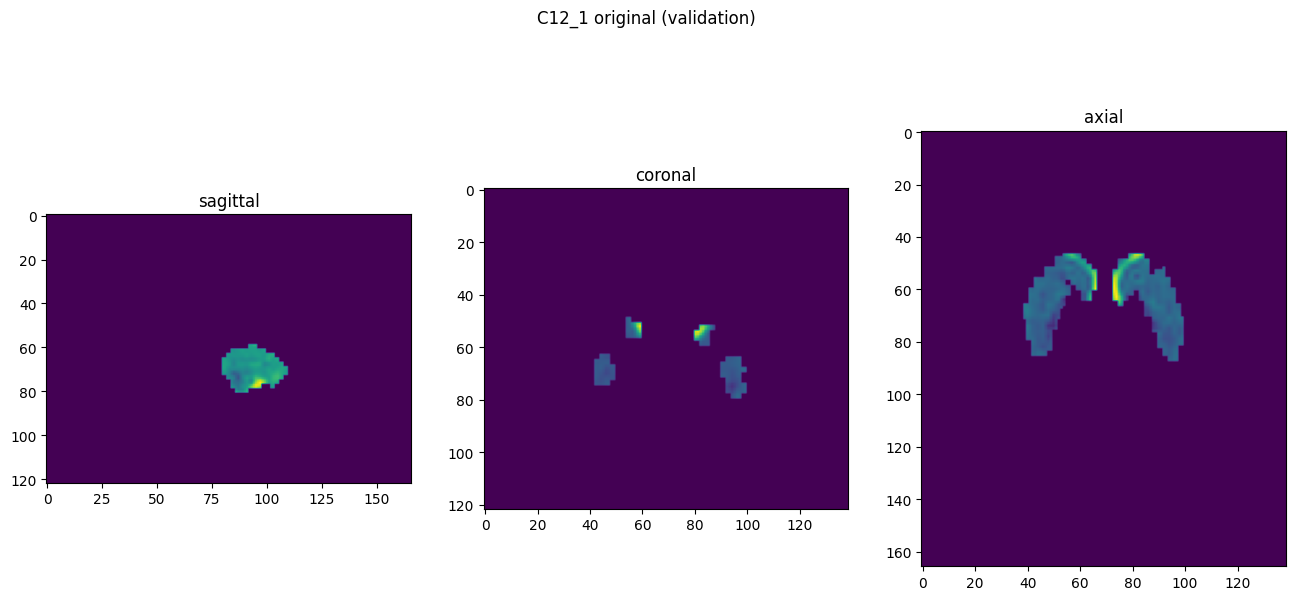

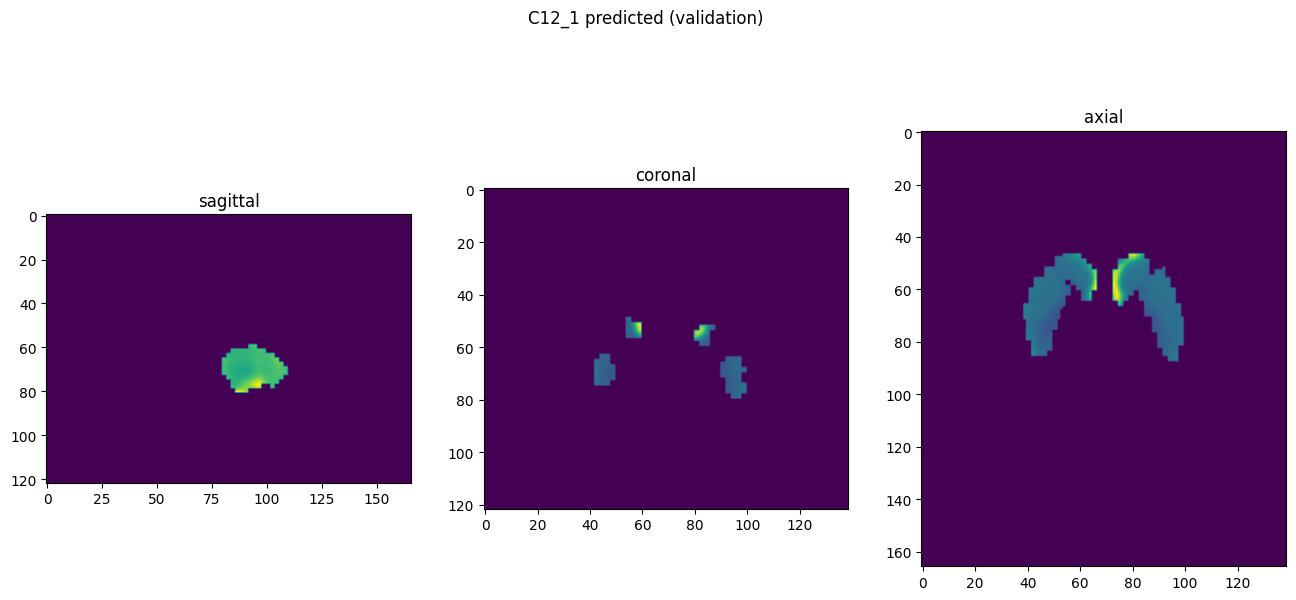

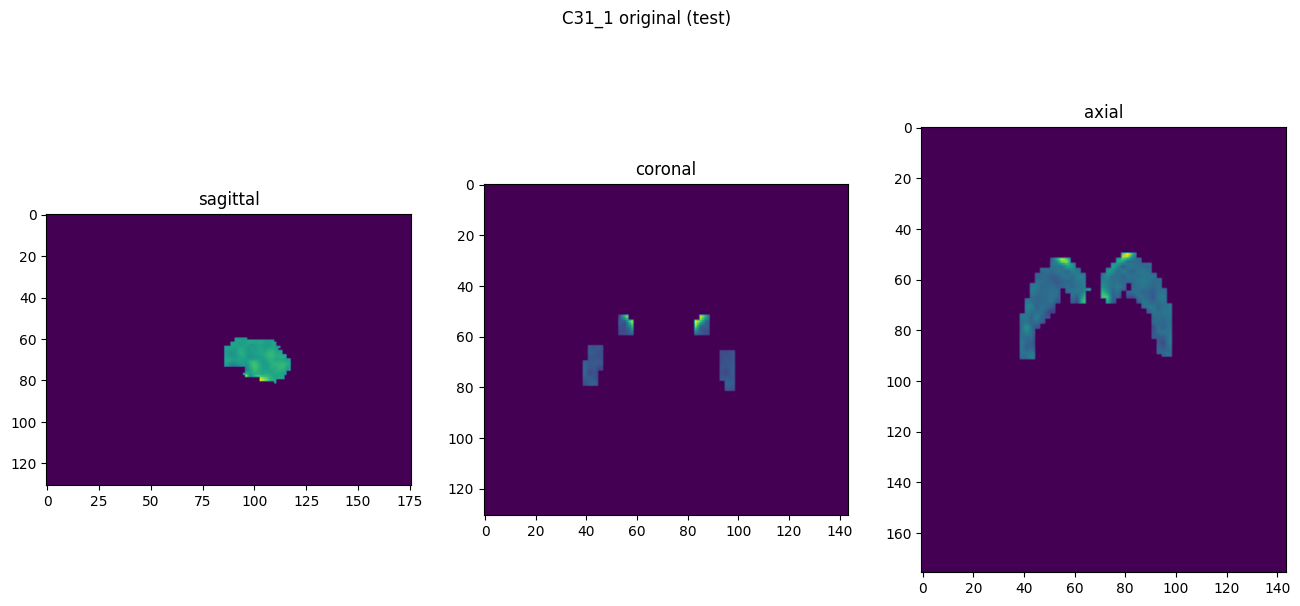

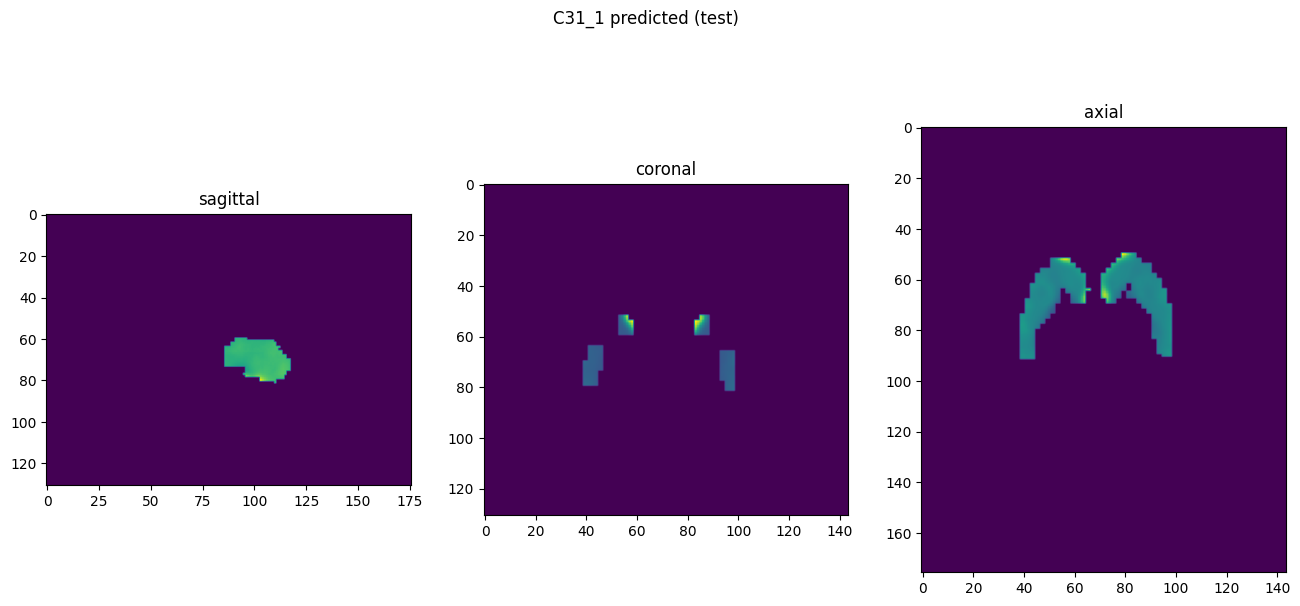

In [10]:
showResults(model, gen, threshold=None, background=False)